In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('/mnt/c/Ryan_Data/Python_Tool/ryan_mplstyle.mplstyle')

import numpy as np

import h5py
import cmocean.cm as cmo
import dedalus.public as d3

In [2]:
Ro = 0.3;
Ly = 16
Ny, Nz = 1024, 16

spname = 'QGpq1_Ro%.2f_Ly%d_Ny%d_Nz%d_snap' %(Ro, Ly, Ny, Nz)
spname = spname.replace(".", "d" ); 
snapname = "../"+spname+"/"+spname+"_s1.h5"

with h5py.File(snapname, mode='r') as file:
    
    G_data = np.squeeze(np.array(file['tasks']['G']))
    q_data = np.squeeze(np.array(file['tasks']['q']))
    # v_data = np.squeeze(np.array(file['tasks']['v']))
    # w_data = np.squeeze(np.array(file['tasks']['w']))
    bt_data = np.squeeze(np.array(file['tasks']['bt']))
    bb_data = np.squeeze(np.array(file['tasks']['bb']))
    absdybt = np.squeeze(np.array(file['tasks']['absdybt']))
    
    sim_time_ary = np.array(file['scales']['sim_time'])
    # print(sim_time_ary)

    y = np.array(file['scales'][list(file['scales'])[-2]])
    z = np.array(file['scales'][list(file['scales'])[-1]])

In [3]:
time_idx = 126

In [4]:
Lz = 1

dealias = 3/2
timestepper = d3.RK111
dtype = np.float64
nu = 0

Ro = 0.3

# Bases
coords = d3.CartesianCoordinates('y', 'z')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.Chebyshev(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)
zbasis = d3.Chebyshev(coords['z'], size=Nz, bounds=(-Lz/2, Lz/2), dealias=dealias)

# Substitutions
dy = lambda A: d3.Differentiate(A, coords['y'])
dz = lambda A: d3.Differentiate(A, coords['z'])

y, z = dist.local_grids(ybasis, zbasis)

lift_basisy = ybasis.derivative_basis(2)
lifty = lambda A, n: d3.Lift(A, lift_basisy, n)
lift_basisz = zbasis.derivative_basis(2)
liftz = lambda A, n: d3.Lift(A, lift_basisz, n)

# Fields
q = dist.Field(name='q', bases=(ybasis,zbasis))

P0 = dist.Field(name='P0', bases=(ybasis,zbasis))
tau_y1 = dist.Field(name='tau_y1', bases=zbasis)
tau_y2 = dist.Field(name='tau_y2', bases=zbasis)
tau_z1 = dist.Field(name='tau_z1', bases=ybasis)
tau_z2 = dist.Field(name='tau_z2', bases=ybasis)
tau_P0 = dist.Field(name='tau_P0')

P1 = dist.Field(name='P1', bases=(ybasis,zbasis))
tau_P1y1 = dist.Field(name='tau_P1y1', bases=zbasis)
tau_P1y2 = dist.Field(name='tau_P1y2', bases=zbasis)
tau_P1z1 = dist.Field(name='tau_P1z1', bases=ybasis)
tau_P1z2 = dist.Field(name='tau_P1z2', bases=ybasis)
tau_P1 = dist.Field(name='tau_P1')

G = dist.Field(name='G', bases=(ybasis,zbasis))
tau_Gy1 = dist.Field(name='tau_Gy1', bases=zbasis)
tau_Gy2 = dist.Field(name='tau_Gy2', bases=zbasis)
tau_Gz1 = dist.Field(name='tau_Gz1', bases=ybasis)
tau_Gz2 = dist.Field(name='tau_Gz2', bases=ybasis)

bt = dist.Field(name='bt', bases=ybasis)
bb = dist.Field(name='bb', bases=ybasis)

u = dist.Field(name='u', bases=(ybasis,zbasis))
b = dist.Field(name='b', bases=(ybasis,zbasis))
zeta = dist.Field(name='zeta', bases=(ybasis,zbasis))

C1 = dist.Field()
D = dist.Field()

# Substitution
Q2 = lambda A: dy(dz(A))
dyy = lambda A: dy(dy(A))

In [5]:
# Problem
# Hacky way of using IVP to solve BVP, just don't put time derivatives
problem = d3.IVP([P0, tau_z1, tau_z2, tau_y1, tau_y2, D, \
                  G, tau_Gz1, tau_Gz2, tau_Gy1, tau_Gy2, \
                  P1, tau_P1z1, tau_P1z2, tau_P1y1, tau_P1y2, C1, \
                  u, zeta, b
                 ], namespace=locals())

problem.add_equation("lap(P0) + liftz(tau_z1,-1) + liftz(tau_z2,-2)  + lifty(tau_y1,-1) + lifty(tau_y2,-2) = 0")
problem.add_equation("integ(P0) = 0")
problem.add_equation("dz(P0)(z=Lz/2) +D = bt")
problem.add_equation("dz(P0)(z=-Lz/2)-D = bb")
problem.add_equation("dy(P0)(y=-Ly/2) = 0")
problem.add_equation("dy(P0)(y=Ly/2) = 0")

problem.add_equation("lap(G) + liftz(tau_Gz1,-1) + liftz(tau_Gz2,-2)  + lifty(tau_Gy1,-1) + lifty(tau_Gy2,-2) -2*Q2(P0) = 0")
problem.add_equation("G(z=-Lz/2) = 0")
problem.add_equation("G(z=Lz/2) = 0")
problem.add_equation("G(y=-Ly/2) = 0")
problem.add_equation("G(y=Ly/2) = 0")

problem.add_equation("lap(P1) + liftz(tau_P1z1,-1) + liftz(tau_P1z2,-2)  + lifty(tau_P1y1,-1) + lifty(tau_P1y2,-2) - C1/Ro = -( dyy(P0)*dz(dz(P0))-dy(dz(P0))**2 )")
problem.add_equation("integ(P1) = 0")
problem.add_equation("dz(P1)(z=Lz/2) = D/Ro")
problem.add_equation("dz(P1)(z=-Lz/2) = -D/Ro")
problem.add_equation("dy(P1)(y=-Ly/2) = 0")
problem.add_equation("dy(P1)(y=Ly/2) = 0")

problem.add_equation("u = -(dy(P0)+Ro*dy(P1))")
problem.add_equation("zeta = -dy(u)")
problem.add_equation("b = dz(P0)+Ro*dz(P1)")

{'LHS': <Field 140018735074864>,
 'RHS': Add(Diff(<Field 140018740874896>), Mul(0.3, Diff(<Field 140018735072512>))),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('float64'),
 'M': 0,
 'L': Convert(<Field 140018735074864>),
 'F': Add(Diff(<Field 140018740874896>), Mul(0.3, Diff(<Field 140018735072512>))),
 'domain': <dedalus.core.domain.Domain at 0x7f58a6f75970>,
 'matrix_dependence': array([False,  True]),
 'matrix_coupling': array([False,  True])}

In [6]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = 1

2024-06-20 14:55:49,409 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s


In [7]:
q.change_scales(1)
bt.change_scales(1)
bb.change_scales(1)

q['g'] = 0
bt['g'] = bt_data[time_idx,:].reshape((Ny, 1))
bb['g'] = bb_data[time_idx,:].reshape((Ny, 1))

solver.step(1e-10); solver.step(1e-10); solver.step(1e-10)

print(Ro*C1['g'])

[[-0.00653775]]


In [8]:
y_p1 = y.ravel()
z_p1 = z.ravel()

b.change_scales(1)
u.change_scales(1)

bg_p1 = b.allgather_data('g')
ug_p1 = u.allgather_data('g')
Gd_p1 = G_data[time_idx,:,:]

In [9]:
Ro = 0.3;
Ly = 16
Ny, Nz = 512, 16

spname = 'SemiG_Ro%.2f_Ly%d_Ny%d_Nz%d_snap' %(Ro, Ly, Ny, Nz)
spname = spname.replace(".", "d" ); 
snapname = "../"+spname+"/"+spname+"_s1.h5"

with h5py.File(snapname, mode='r') as file:
    
    G_data = np.squeeze(np.array(file['tasks']['G']))
    P0_data = np.squeeze(np.array(file['tasks']['P0']))
    b_data = np.squeeze(np.array(file['tasks']['b']))
    v_data = np.squeeze(np.array(file['tasks']['v']))
    w_data = np.squeeze(np.array(file['tasks']['w']))
    bt_data = np.squeeze(np.array(file['tasks']['bt']))
    bb_data = np.squeeze(np.array(file['tasks']['bb']))

    absdybt = np.squeeze(np.array(file['tasks']['absdybt']))
    
    sim_time_ary = np.array(file['scales']['sim_time'])
    # print(sim_time_ary)
    
    y = np.array(file['scales'][list(file['scales'])[-2]])
    z = np.array(file['scales'][list(file['scales'])[-1]])

In [10]:
time_idx = 120

In [11]:
# Parameters
Ly, Lz = 16, 1

dealias = 3/2
dtype = np.float64

Ro = 0.3

# Bases
coords = d3.CartesianCoordinates('y', 'z')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.Chebyshev(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)
zbasis = d3.Chebyshev(coords['z'], size=Nz, bounds=(-Lz/2, Lz/2), dealias=dealias)

# Substitutions
dy = lambda A: d3.Differentiate(A, coords['y'])
dz = lambda A: d3.Differentiate(A, coords['z'])

y, z = dist.local_grids(ybasis, zbasis)

lift_basisy = ybasis.derivative_basis(2)
lifty = lambda A, n: d3.Lift(A, lift_basisy, n)
lift_basisz = zbasis.derivative_basis(2)
liftz = lambda A, n: d3.Lift(A, lift_basisz, n)

In [12]:
b = dist.Field(bases=(ybasis,zbasis))
b['g'] = b_data[time_idx,:]

q = dist.Field(bases=(ybasis,zbasis))

In [13]:
psi = dist.Field(bases=(ybasis,zbasis))
tau_y1 = dist.Field(bases=ybasis)
qq = dist.Field(bases=(ybasis,zbasis))
u = dist.Field(bases=(ybasis,zbasis))
zeta = dist.Field(bases=(ybasis,zbasis))

problem = d3.IVP([psi, tau_y1, qq, u, zeta], namespace=locals())
problem.add_equation("dz(psi) + liftz(tau_y1,-1) = b")
problem.add_equation("psi(z=0) = 0")
problem.add_equation("qq - lap(psi)= Ro*( dy(dy(psi))*dz(dz(psi))-dy(dz(psi))*dy(dz(psi)) )")
problem.add_equation("u = -dy(psi)")
problem.add_equation("zeta = -dy(u)")

###
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = 10

###
solver.step(1e-10); solver.step(1e-10); solver.step(1e-10); solver.step(1e-10); solver.step(1e-10)

2024-06-20 14:55:51,767 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.5e+00/s


In [14]:
b.change_scales(1)
u.change_scales(1)

In [15]:
# import matplotlib.gridspec as gridspec

# fig = plt.figure(figsize=(6, 2.))

# gs = gridspec.GridSpec(1, 4, width_ratios=[1,0.05,1,.07])
# fig.subplots_adjust(wspace=0.15, hspace=0)

# ax = fig.add_subplot(gs[0])
# ax.contour(y_p1, z_p1, (Ro*bg_p1+z).T, np.arange(-3,3.3,0.1), colors='black', linewidths=0.8)
# ax.contourf(y_p1, z_p1, Ro*ug_p1.T, 15, cmap=cmo.balance)
# ax.set_xlim(-2,2)
# ax.set_xticks([])
# ax.set_yticks([])

# ax2 = fig.add_subplot(gs[2])
# ax2.contour(y.ravel(), z.ravel(), (Ro*b.allgather_data('g')+z).T, np.arange(-3,3.3,0.1), colors='black', linewidths=0.8)
# im = ax2.contourf(y.ravel(), z.ravel(), Ro*u.allgather_data('g').T, 15, cmap=cmo.balance)
# ax2.set_xlim(-2,2)
# ax2.set_xticks([])
# ax2.set_yticks([])

# cax = fig.add_subplot(gs[3])
# fig.colorbar(im, cax=cax)

# figname = 'figs/2DF_u'
# figname = figname.replace(".", "d" ); figname = figname+'.pdf'
# # plt.savefig(figname, bbox_inches='tight')

In [16]:
# import matplotlib.gridspec as gridspec

# fig = plt.figure(figsize=(6, 2.))

# gs = gridspec.GridSpec(1, 4, width_ratios=[1,0.05,1,.07])
# fig.subplots_adjust(wspace=0.15, hspace=0)

# ax = fig.add_subplot(gs[0])
# ax.contour(y_p1, z_p1, (Ro*bg_p1+z).T, np.arange(-3,3.3,0.1), colors='black', linewidths=0.8)
# ax.contourf(y_p1, z_p1, Gd_p1.T, np.arange(0,0.4,0.04) , cmap=cmo.amp)
# ax.set_xlim(-2,2)
# ax.set_xticks([])
# ax.set_yticks([])

# ax2 = fig.add_subplot(gs[2])
# ax2.contour(y.ravel(), z.ravel(), (Ro*b.allgather_data('g')+z).T, np.arange(-3,3.3,0.1), colors='black', linewidths=0.8)
# im = ax2.contourf(y.ravel(), z.ravel(), G_data[time_idx,:,:].T, np.arange(0,0.4,0.04) , cmap=cmo.amp)
# ax2.set_xlim(-2,2)
# ax2.set_xticks([])
# ax2.set_yticks([])

# cax = fig.add_subplot(gs[3])
# fig.colorbar(im, cax=cax)

# figname = 'figs/2DF_G'
# figname = figname.replace(".", "d" ); figname = figname+'.pdf'
# # plt.savefig(figname, bbox_inches='tight')

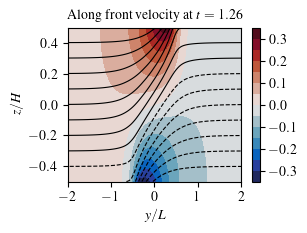

In [17]:
import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=(2.8, 2.0))

plt.contour(y_p1, z_p1, (Ro*bg_p1+z).T, np.arange(-3,3.3,0.1), colors='black', linewidths=0.8)
plt.contourf(y_p1, z_p1, Ro*ug_p1.T, 15, cmap=cmo.balance)
# plt.xticks([]); 
# plt.yticks([])
plt.xlabel("$y/L$"); 
plt.ylabel("$z/H$")

clb = plt.colorbar()
plt.xlim([-2,2])
plt.title("Along front velocity at $t=1.26$")

figname = 'figs/2DF_u'
figname = figname.replace(".", "d" ); figname = figname+'.pdf'
plt.savefig(figname, bbox_inches='tight')

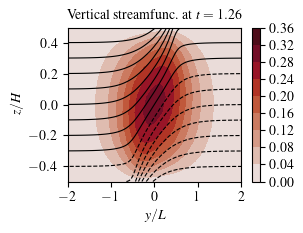

In [18]:
import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=(2.8, 2.0))

plt.contour(y_p1, z_p1, (Ro*bg_p1+z).T, np.arange(-3,3.3,0.1), colors='black', linewidths=0.8)
plt.contourf(y_p1, z_p1, Gd_p1.T, np.arange(0,0.4,0.04) , cmap=cmo.amp)
# plt.xticks([]); 
# plt.yticks([])
plt.xlabel("$y/L$"); 
plt.ylabel("$z/H$")

clb = plt.colorbar()
plt.xlim([-2,2])
plt.title("Vertical streamfunc. at $t=1.26$")

figname = 'figs/2DF_G'
figname = figname.replace(".", "d" ); figname = figname+'.pdf'
plt.savefig(figname, bbox_inches='tight')